In [1]:
# ============================================
#  Setup and Download Dataset
# ============================================

!pip install xgboost -q

import urllib.request
import zipfile
import os

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Download dataset from UCI
print("Downloading Air Quality Dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
zip_path = "data/AirQualityUCI.zip"

urllib.request.urlretrieve(url, zip_path)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')

print("✓ Dataset downloaded and extracted successfully!")
print("\nFiles in data folder:")
!ls -la data/

✓ Dataset downloaded and extracted successfully!

Files in data folder:
total 3552
drwxr-xr-x 2 root root    4096 Dec 28 11:17 .
drwxr-xr-x 1 root root    4096 Dec 28 11:17 ..
-rw-r--r-- 1 root root  785065 Dec 28 11:17 AirQualityUCI.csv
-rw-r--r-- 1 root root 1298197 Dec 28 11:17 AirQualityUCI.xlsx
-rw-r--r-- 1 root root 1543989 Dec 28 11:17 AirQualityUCI.zip


In [2]:
# ============================================
# Import Libraries
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    from sklearn.ensemble import GradientBoostingRegressor
    XGBOOST_AVAILABLE = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("✓ All libraries imported successfully!")
print(f"✓ XGBoost available: {XGBOOST_AVAILABLE}")

✓ All libraries imported successfully!
✓ XGBoost available: True


In [3]:
# ============================================
#  Load and Explore Dataset
# ============================================

# Load dataset
df = pd.read_csv(
    'data/AirQualityUCI.csv',
    sep=';',
    decimal=',',
    na_values=['', ' ', -200, '-200'],
    encoding='latin-1'
)

print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"\nShape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumns:\n{df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nFirst 5 rows:")
df.head()

DATASET OVERVIEW

Shape: 9471 rows, 17 columns

Columns:
['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16']

Data Types:
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
Unnamed: 15      float64
Unnamed: 16      float64
dtype: object

First 5 rows:


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [4]:
# ============================================
#  Data Cleaning
# ============================================

print("=" * 50)
print("DATA CLEANING")
print("=" * 50)

# Remove empty columns
df = df.dropna(axis=1, how='all')
print(f"\n1. After removing empty columns: {df.shape}")

# Remove Date and Time columns
columns_to_drop = ['Date', 'Time', 'Unnamed: 15', 'Unnamed: 16']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
print(f"2. After removing Date/Time: {df.shape}")

# Replace -200 with NaN (sensor error)
df = df.replace(-200, np.nan)
df = df.replace(-200.0, np.nan)

# Show missing values
print("\n3. Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing'] > 0])

# Remove rows with >50% missing values
threshold = len(df.columns) * 0.5
df = df.dropna(thresh=int(threshold))
print(f"\n4. After removing rows with >50% missing: {df.shape}")

# Fill remaining missing values with median
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

print(f"5. After filling missing values: {df.shape}")
print(f"\n✓ Remaining missing values: {df.isnull().sum().sum()}")

# Show cleaned data info
print("\n" + "=" * 50)
print("CLEANED DATA SUMMARY")
print("=" * 50)
df.describe()

DATA CLEANING

1. After removing empty columns: (9471, 15)
2. After removing Date/Time: (9471, 13)

3. Missing Values:
               Missing  Percentage
CO(GT)            1797       18.97
PT08.S1(CO)        480        5.07
NMHC(GT)          8557       90.35
C6H6(GT)           480        5.07
PT08.S2(NMHC)      480        5.07
NOx(GT)           1753       18.51
PT08.S3(NOx)       480        5.07
NO2(GT)           1756       18.54
PT08.S4(NO2)       480        5.07
PT08.S5(O3)        480        5.07
T                  480        5.07
RH                 480        5.07
AH                 480        5.07

4. After removing rows with >50% missing: (8991, 13)
5. After filling missing values: (8991, 13)

✓ Remaining missing values: 0

CLEANED DATA SUMMARY


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.069314,1099.833166,152.261706,10.083105,939.153376,230.802135,835.493605,111.586142,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.304487,217.080037,68.476916,7.449820,266.831429,188.717210,256.817320,43.205808,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.200000,937.000000,145.000000,4.400000,734.500000,112.000000,658.000000,85.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,145.000000,8.200000,909.000000,178.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.600000,1231.000000,145.000000,14.000000,1116.000000,280.000000,969.500000,132.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,333.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


FEATURE PREPARATION

Target Variable: C6H6(GT)
Number of Features: 12
Features: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

Target Statistics:
count    8991.000000
mean       10.083105
std         7.449820
min         0.100000
25%         4.400000
50%         8.200000
75%        14.000000
max        63.700000
Name: C6H6(GT), dtype: float64


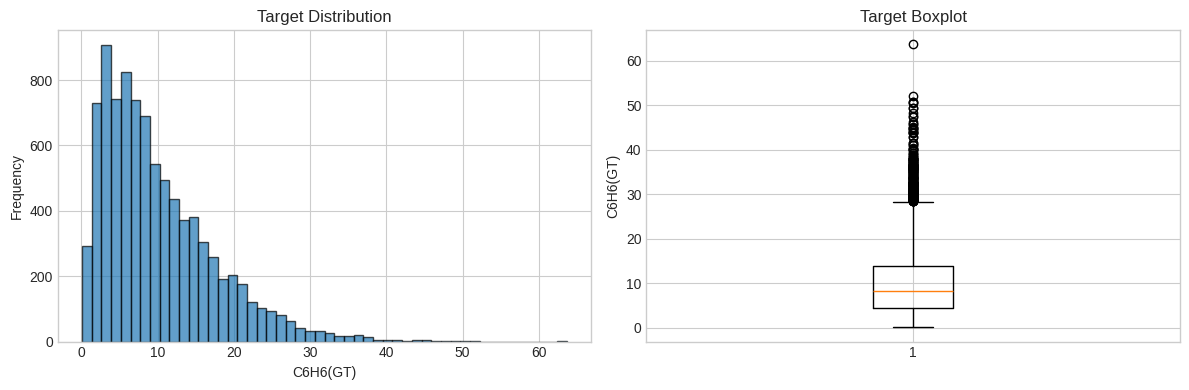

In [5]:
# ============================================
# Prepare Features and Target
# ============================================

# Define target column (Benzene concentration)
TARGET_COLUMN = 'C6H6(GT)'

print("=" * 50)
print("FEATURE PREPARATION")
print("=" * 50)

# Check if target exists
if TARGET_COLUMN not in df.columns:
    print(f"Available columns: {df.columns.tolist()}")
    raise ValueError(f"Target column '{TARGET_COLUMN}' not found!")

# Separate features and target
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

feature_names = list(X.columns)

print(f"\nTarget Variable: {TARGET_COLUMN}")
print(f"Number of Features: {len(feature_names)}")
print(f"Features: {feature_names}")
print(f"\nTarget Statistics:")
print(y.describe())

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel(TARGET_COLUMN)
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Distribution')

axes[1].boxplot(y)
axes[1].set_ylabel(TARGET_COLUMN)
axes[1].set_title('Target Boxplot')

plt.tight_layout()
plt.show()

In [6]:
# ============================================
#  Train/Test Split and Scaling
# ============================================

print("=" * 50)
print("DATA SPLITTING AND SCALING")
print("=" * 50)

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features
# IMPORTANT: Fit scaler ONLY on training data!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled using StandardScaler")
print("✓ Scaler fitted on training data ONLY (no data leakage)")

# Also keep unscaled versions for bonus comparison
X_train_unscaled = X_train.values
X_test_unscaled = X_test.values

# Convert y to numpy arrays
y_train = y_train.values
y_test = y_test.values

print("\n✓ Data preparation complete!")

DATA SPLITTING AND SCALING

Train set: 7192 samples
Test set: 1799 samples

✓ Features scaled using StandardScaler
✓ Scaler fitted on training data ONLY (no data leakage)

✓ Data preparation complete!


In [7]:
# ============================================
#  Define and Train Models
# ============================================

print("=" * 50)
print("MODEL TRAINING")
print("=" * 50)

# Define models with their parameters
models = {
    'Linear Regression': LinearRegression(),

    'KNN Regressor': KNeighborsRegressor(
        n_neighbors=5,
        metric='euclidean'
    ),

    'Decision Tree': DecisionTreeRegressor(
        max_depth=5,
        random_state=42
    ),

    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    ),

    'XGBoost': XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    ) if XGBOOST_AVAILABLE else GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
}

# Train all models and store results
results = []

for name, model in models.items():
    print(f"\nTraining {name}...", end=" ")

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2,
        'Predictions': y_pred
    })

    print(f"Done! R² = {r2:.4f}")

print("\n✓ All models trained successfully!")

MODEL TRAINING

Training Linear Regression... Done! R² = 0.9764

Training KNN Regressor... Done! R² = 0.9776

Training Decision Tree... Done! R² = 0.9971

Training Random Forest... Done! R² = 0.9992

Training XGBoost... Done! R² = 0.9985

✓ All models trained successfully!


In [8]:
# ============================================
#  Model Comparison Table
# ============================================

print("=" * 50)
print("MODEL COMPARISON RESULTS")
print("=" * 50)

# Create comparison DataFrame
comparison_df = pd.DataFrame([{
    'Model': r['Model'],
    'MSE': round(r['MSE'], 4),
    'RMSE': round(r['RMSE'], 4),
    'MAE': round(r['MAE'], 4),
    'R2 Score': round(r['R2 Score'], 4)
} for r in results])

# Sort by R2 Score
comparison_df = comparison_df.sort_values('R2 Score', ascending=False).reset_index(drop=True)

print("\n")
print(comparison_df.to_string(index=False))

# Find best model
best_idx = comparison_df['R2 Score'].idxmax()
best_model = comparison_df.loc[best_idx, 'Model']
best_r2 = comparison_df.loc[best_idx, 'R2 Score']

print(f"\n🏆 BEST MODEL: {best_model} with R² = {best_r2}")

# Save to CSV
comparison_df.to_csv('results/comparison_table.csv', index=False)
print("\n✓ Comparison table saved to results/comparison_table.csv")

MODEL COMPARISON RESULTS


            Model    MSE   RMSE    MAE  R2 Score
    Random Forest 0.0432 0.2078 0.1263    0.9992
          XGBoost 0.0874 0.2956 0.0624    0.9985
    Decision Tree 0.1646 0.4058 0.2612    0.9971
    KNN Regressor 1.2896 1.1356 0.7118    0.9776
Linear Regression 1.3544 1.1638 0.8459    0.9764

🏆 BEST MODEL: Random Forest with R² = 0.9992

✓ Comparison table saved to results/comparison_table.csv


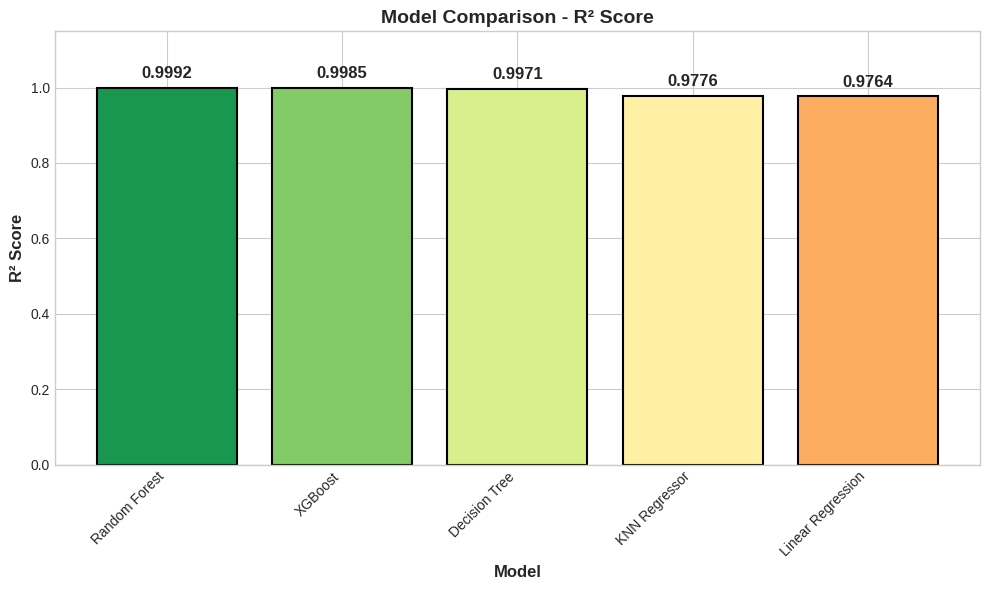

✓ R² comparison chart saved to results/r2_comparison.png


In [9]:
# ============================================
#  R² Score Comparison Chart
# ============================================

fig, ax = plt.subplots(figsize=(10, 6))

models_list = comparison_df['Model'].tolist()
r2_scores = comparison_df['R2 Score'].tolist()

# Create color gradient
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(models_list)))
sorted_indices = np.argsort(r2_scores)
color_map = [colors[list(sorted_indices).index(i)] for i in range(len(models_list))]

bars = ax.bar(models_list, r2_scores, color=color_map, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax.annotate(
        f'{score:.4f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - R² Score', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(r2_scores) * 1.15)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('results/r2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ R² comparison chart saved to results/r2_comparison.png")

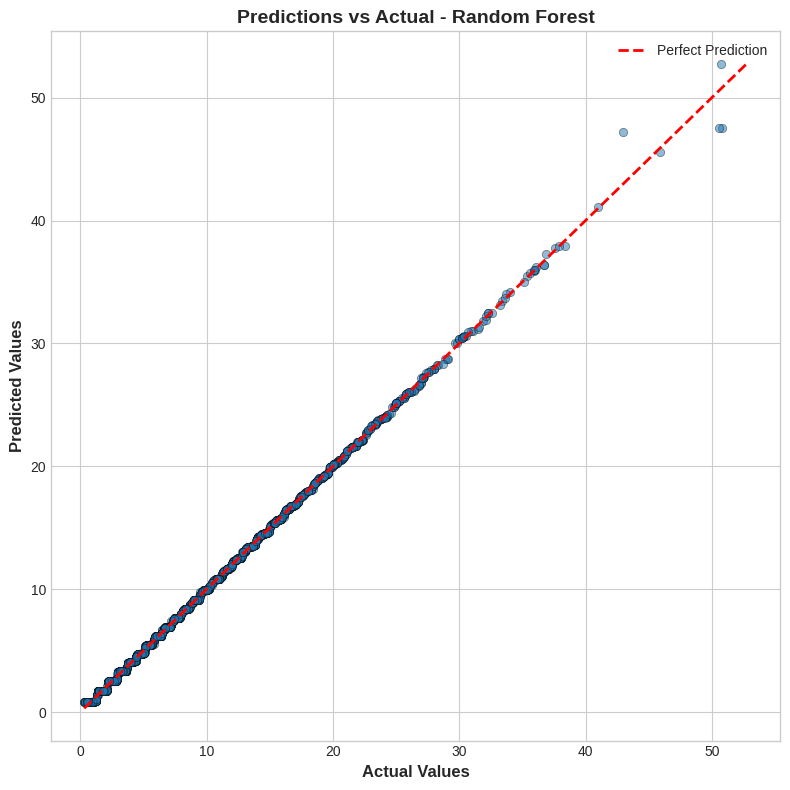

✓ Predictions plot saved for Random Forest


In [10]:
# ============================================
#  Predictions vs Actual (Best Model)
# ============================================

# Get best model's predictions
best_result = next(r for r in results if r['Model'] == best_model)
best_predictions = best_result['Predictions']

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(y_test, best_predictions, alpha=0.5, edgecolors='black', linewidth=0.5)

# Perfect prediction line
min_val = min(y_test.min(), best_predictions.min())
max_val = max(y_test.max(), best_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('Actual Values', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
ax.set_title(f'Predictions vs Actual - {best_model}', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('results/predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Predictions plot saved for {best_model}")

BONUS: FEATURE IMPORTANCE ANALYSIS


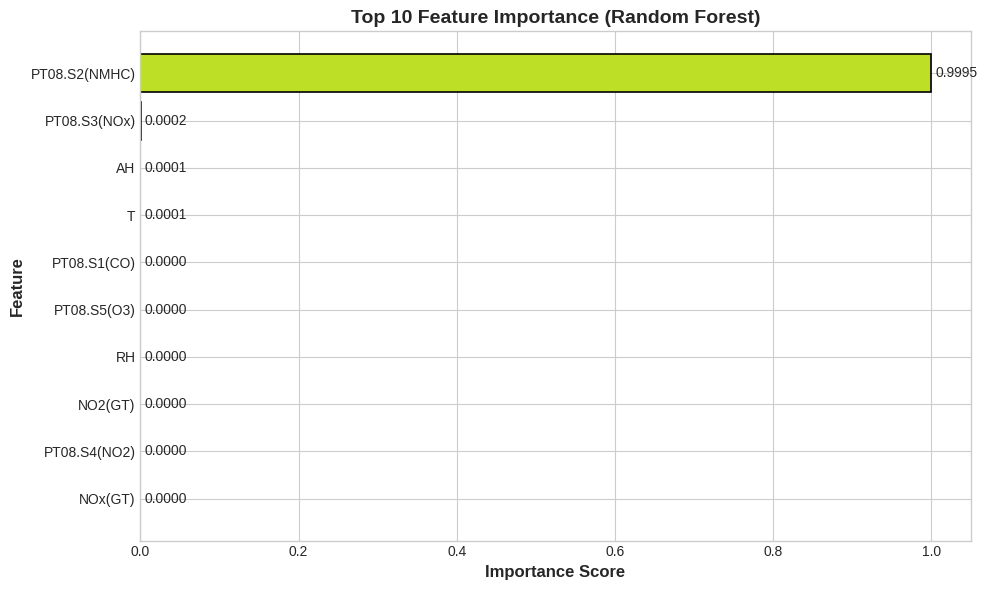


Top 5 Most Important Features:
  1. PT08.S2(NMHC): 0.9995
  2. PT08.S3(NOx): 0.0002
  3. AH: 0.0001
  4. T: 0.0001
  5. PT08.S1(CO): 0.0000

✓ Feature importance plot saved


In [11]:
# ============================================
#  Feature Importance Analysis (BONUS)
# ============================================

print("=" * 50)
print("BONUS: FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get Random Forest model
rf_model = models['Random Forest']
importance_scores = rf_model.feature_importances_

# Sort features by importance
indices = np.argsort(importance_scores)[::-1]
top_n = min(10, len(feature_names))

top_features = [feature_names[i] for i in indices[:top_n]]
top_scores = importance_scores[indices[:top_n]]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))[::-1]

bars = ax.barh(range(len(top_features)), top_scores, color=colors, edgecolor='black', linewidth=1.2)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features)
ax.invert_yaxis()

# Add value labels
for bar, score in zip(bars, top_scores):
    width = bar.get_width()
    ax.annotate(
        f'{score:.4f}',
        xy=(width, bar.get_y() + bar.get_height() / 2),
        xytext=(3, 0),
        textcoords="offset points",
        ha='left',
        va='center',
        fontsize=10
    )

ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Feature Importance (Random Forest)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('results/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top features
print("\nTop 5 Most Important Features:")
for i, (feat, score) in enumerate(zip(top_features[:5], top_scores[:5]), 1):
    print(f"  {i}. {feat}: {score:.4f}")

print("\n✓ Feature importance plot saved")

BONUS: SCALING IMPACT ANALYSIS


        Model  R2 (Scaled)  R2 (Unscaled)  Difference
KNN Regressor       0.9776         0.9869     -0.0094
Random Forest       0.9992         0.9992      0.0000


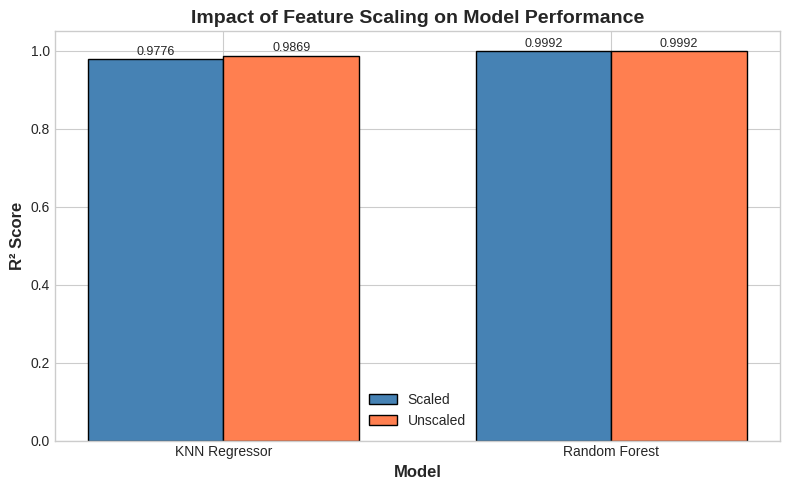


✓ Scaling comparison saved


In [12]:
# ============================================
#  Scaling Impact Comparison (BONUS)
# ============================================

print("=" * 50)
print("BONUS: SCALING IMPACT ANALYSIS")
print("=" * 50)

# Models to compare
scaling_comparison = []

for name in ['KNN Regressor', 'Random Forest']:
    # Get scaled results
    scaled_result = next(r for r in results if r['Model'] == name)

    # Train without scaling
    if name == 'KNN Regressor':
        model_unscaled = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
    else:
        model_unscaled = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)

    model_unscaled.fit(X_train_unscaled, y_train)
    y_pred_unscaled = model_unscaled.predict(X_test_unscaled)
    r2_unscaled = r2_score(y_test, y_pred_unscaled)

    scaling_comparison.append({
        'Model': name,
        'R2 (Scaled)': round(scaled_result['R2 Score'], 4),
        'R2 (Unscaled)': round(r2_unscaled, 4),
        'Difference': round(scaled_result['R2 Score'] - r2_unscaled, 4)
    })

scaling_df = pd.DataFrame(scaling_comparison)
print("\n")
print(scaling_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(scaling_df))
width = 0.35

bars1 = ax.bar(x - width/2, scaling_df['R2 (Scaled)'], width, label='Scaled', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, scaling_df['R2 (Unscaled)'], width, label='Unscaled', color='coral', edgecolor='black')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Impact of Feature Scaling on Model Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scaling_df['Model'])
ax.legend()

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('results/scaling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save to CSV
scaling_df.to_csv('results/scaling_comparison.csv', index=False)
print("\n✓ Scaling comparison saved")

In [13]:
# ============================================
#  FINAL SUMMARY
# ============================================

print("=" * 60)
print("   PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)

print(f"""
📊 RESULTS SUMMARY
{'─' * 40}

Dataset Info:
  • Total Samples: {len(df)}
  • Features: {len(feature_names)}
  • Target: {TARGET_COLUMN}
  • Train/Test Split: 80% / 20%

Best Model Performance:
  • Model: {best_model}
  • R² Score: {best_r2:.4f}
  • MSE: {comparison_df.loc[comparison_df['Model'] == best_model, 'MSE'].values[0]:.4f}

Top 3 Important Features:
  1. {top_features[0]}
  2. {top_features[1]}
  3. {top_features[2]}

Files Generated:
  • results/comparison_table.csv
  • results/r2_comparison.png
  • results/predictions_vs_actual.png
  • results/feature_importance.png
  • results/scaling_comparison.png
  • results/scaling_comparison.csv
""")

# Show all generated files
print("\n📁 Generated Files:")
!ls -la results/

   PROJECT COMPLETED SUCCESSFULLY!

📊 RESULTS SUMMARY
────────────────────────────────────────

Dataset Info:
  • Total Samples: 8991
  • Features: 12
  • Target: C6H6(GT)
  • Train/Test Split: 80% / 20%

Best Model Performance:
  • Model: Random Forest
  • R² Score: 0.9992
  • MSE: 0.0432

Top 3 Important Features:
  1. PT08.S2(NMHC)
  2. PT08.S3(NOx)
  3. AH

Files Generated:
  • results/comparison_table.csv
  • results/r2_comparison.png
  • results/predictions_vs_actual.png
  • results/feature_importance.png
  • results/scaling_comparison.png
  • results/scaling_comparison.csv


📁 Generated Files:
total 704
drwxr-xr-x 2 root root   4096 Dec 28 11:18 .
drwxr-xr-x 1 root root   4096 Dec 28 11:17 ..
-rw-r--r-- 1 root root    236 Dec 28 11:17 comparison_table.csv
-rw-r--r-- 1 root root 164691 Dec 28 11:17 feature_importance.png
-rw-r--r-- 1 root root 276803 Dec 28 11:17 predictions_vs_actual.png
-rw-r--r-- 1 root root 152847 Dec 28 11:17 r2_comparison.png
-rw-r--r-- 1 root root    111 D

In [14]:
# ============================================
# Download Results
# ============================================

from google.colab import files
import shutil

# Create zip file of results
shutil.make_archive('air_quality_results', 'zip', 'results')

# Download
files.download('air_quality_results.zip')

print("✓ Results downloaded as zip file!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Results downloaded as zip file!
